# Function Interpolation

Interpolate a function via splines, GPs or GAMs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from csaps import CubicSmoothingSpline

np.set_printoptions(precision=2)

plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.family'] = 'monospace'

## Gaussian Process

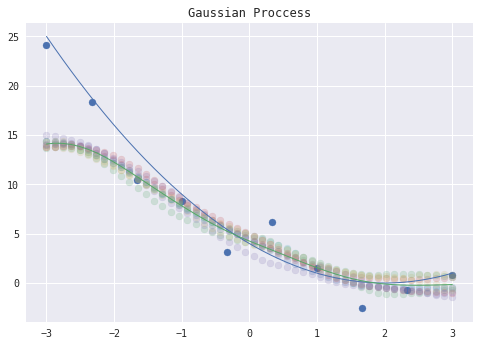

In [9]:
@np.vectorize
def foo(x):
    return (x-2.)**2

plt.plot(Xt:=np.linspace(-3, 3, 50)[:, np.newaxis], foo(Xt))
m = GaussianProcessRegressor(
    alpha=1.,
    kernel=kernels.Matern(),
)
m.fit(X:=np.linspace(-3, 3, 10)[:, np.newaxis], y:=foo(X[:, 0])+np.random.normal(scale=2., size=len(X)))
plt.scatter(X, y)
plt.plot(Xt, yt:=m.predict(Xt))
for i in range((samples:=m.sample_y(Xt, 10)).shape[-1]):
    plt.scatter(Xt, samples[:, i], alpha=0.2)
plt.title('Gaussian Proccess')
_=_

## Natural Cubic Spline

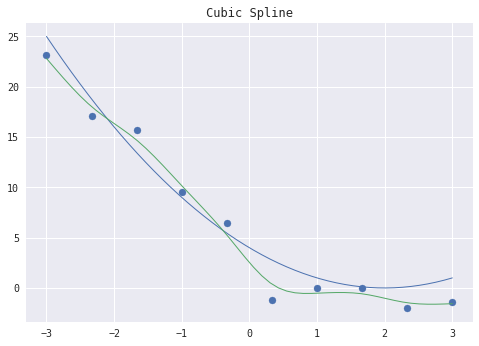

In [8]:
plt.plot(Xt, foo(Xt))
plt.scatter(X, y)

m = CubicSmoothingSpline(X[:, 0], y)
plt.plot(Xt[:, 0], yt:=m.spline(Xt[:, 0]))
plt.title('Cubic Spline')
_=_

## GAM

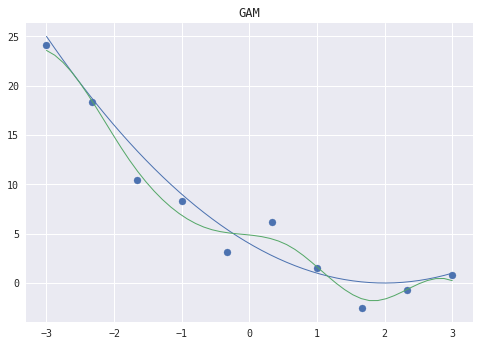

In [11]:
from mlutil.model import GAM as GAM1

plt.plot(Xt, foo(Xt))
plt.scatter(X, y)

m = GAM1()
m.fit(X, y)
plt.plot(Xt, yt:=m.predict(Xt))
plt.title('GAM (statsmodels + mlutil)')
_=_

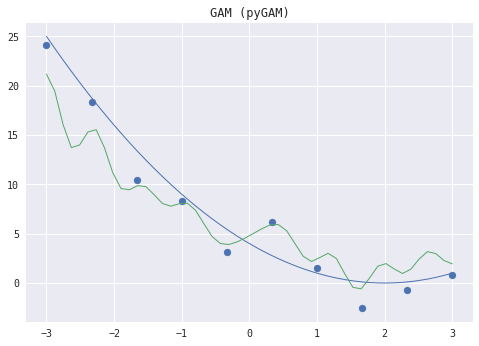

In [32]:
from pygam import LinearGAM as GAM2

plt.plot(Xt, foo(Xt))
plt.scatter(X, y)

m = GAM2(lam=0.025)
# m.gridsearch(X, y, objective='AIC')
m.fit(X, y)
plt.plot(Xt, yt:=m.predict(Xt))
plt.title('GAM (pyGAM)')
_=_